In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

sex : patient's gender (1: male; 0: female)

cp : Chest pain type: 0: asymptomatic 1: typical angina 2: atypical angina 3: non-anginal pain

trestbps : Resting blood pressure (in mm Hg)

chol : Serum cholestoral in mg/dl

fbs : if the patient's fasting blood sugar > 120 mg/dl (1: yes; 0: no)

restecg : Resting ECG results: 0: normal 1: ST-T wave abnormality (T wave inversions and/or ST elevation or depression 

thalach : Maximum heart rate achieved.

exang : Exercise induced angina (1: yes; 0: no)

oldpeak : ST depression induced by exercise relative to rest.

slope : The slope of the peak exercise ST segment: 0: upsloping 1: flat 2: downsloping

ca : Number of major vessels (0–3) colored by flourosopy

thal : 3: Normal; 6: Fixed defect; 7: Reversable defect

target : Whether the patient has hypertension (1) or not (0)

In [26]:
df = pd.read_csv('./hypertension_data.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,57.0,1.0,3,145,233,1,0,150,0,2.3,0,0,1,1
1,64.0,0.0,2,130,250,0,1,187,0,3.5,0,0,2,1
2,52.0,1.0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56.0,0.0,1,120,236,0,1,178,0,0.8,2,0,2,1
4,66.0,0.0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26078,72.0,0.0,0,138,294,1,1,106,0,1.9,1,3,2,0
26079,60.0,1.0,0,144,200,0,0,126,1,0.9,1,0,3,0
26080,68.0,1.0,0,100,234,0,1,156,0,0.1,2,1,3,0
26081,67.0,1.0,1,154,232,0,0,164,0,0.0,2,1,2,0


In [27]:
df=df.dropna()

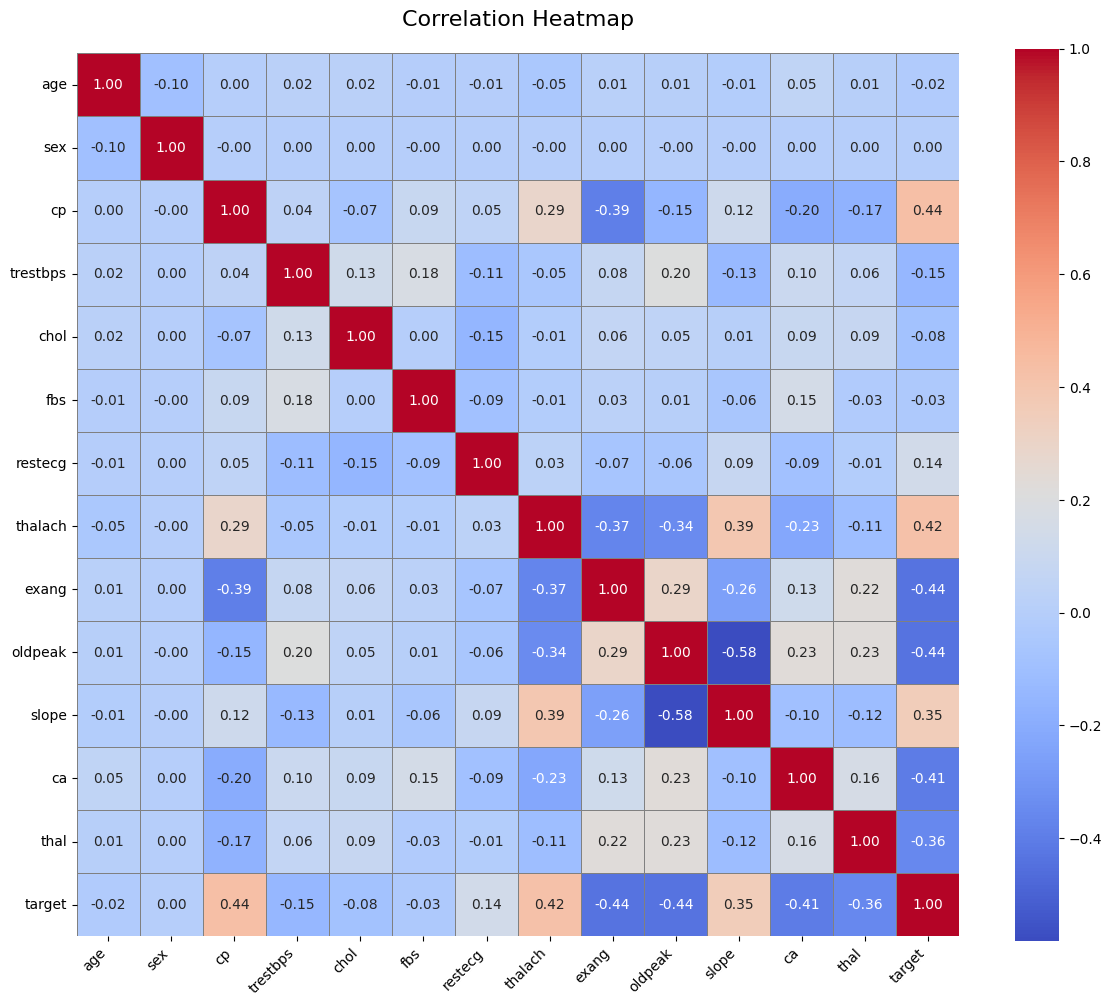

In [28]:
corr = df.corr() 

# Set the figure size and font
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=0.5,       # Adds gridlines
            linecolor='gray',     # Color of the gridlines
            square=True,          # Makes each cell square-shaped
            annot_kws={"size": 10})  # Font size of annotations

# Improve tick label orientation and readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

# Title formatting
plt.title("Correlation Heatmap", fontsize=16, pad=20)

# Tight layout for spacing
plt.tight_layout()

# Show plot
plt.show()

In [29]:
X = df.drop(columns=['target', 'sex', 'fbs', 'oldpeak']).to_numpy()
y = df['target'].to_numpy()

X_train, X_, y_train, y_ = train_test_split(X,y, test_size=0.40, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_, test_size=0.50, random_state=42)

In [30]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

In [31]:
def sigmoid(z):
    z = np.clip(z, -500, 500)  # Clip values to prevent overflow
    return 1 / (1 + np.exp(-z))

In [32]:
def compute_cost(X, y, w, b, lambda_):
    m, n = X.shape

    loss_sum = 0.0
    epsilon = 1e-10  # Avoid log(0) issues
    for i in range(m):
        z_wb = np.dot(w, X[i]) + b
        f_wb = sigmoid(z_wb)
        # loss = -y[i] * np.log(f_wb) - (1-y[i]) * np.log(1 - f_wb) 
        loss = -y[i] * np.log(np.clip(f_wb, epsilon, 1 - epsilon)) - (1 - y[i]) * np.log(np.clip(1 - f_wb, epsilon, 1 - epsilon))
        loss_sum += loss

    cost = loss_sum / m
    reg_cost = 0.0
    for j in range(n):
        reg_cost_j = w[j] ** 2
        reg_cost += reg_cost_j
    reg_cost = (lambda_ / (2 * m)) * reg_cost
    total_cost = reg_cost + cost    
    return total_cost

In [33]:
np.random.seed(42)
initial_w = np.random.rand(X_train.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5
cost = compute_cost(X_train, y_train, initial_w, initial_b, lambda_)

print("Regularized cost :", cost)

Regularized cost : 0.6988439335311086


In [34]:
def compute_gradient(X, y, w, b, lambda_):
    m,n = X.shape
    dj_dw = 0.
    dj_db = 0.

    for i in range(m):
        z_wb = np.dot(w, X[i]) + b
        f_wb = sigmoid(z_wb)
        dj_dw += (f_wb - y[i]) * X[i]
        dj_db += (f_wb - y[i])
    
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    
    for j in range(n):
        dj_dw[j] += (lambda_/m) * w[j]

    return dj_dw, dj_db

In [35]:
# test
initial_w  = np.random.rand(X_train.shape[1]) - 0.5 
initial_b = 0.5
 
lambda_ = 0.5
dj_dw, dj_db = compute_gradient(X_train, y_train, initial_w, initial_b, lambda_)
print(dj_dw, "and", dj_db)

[-0.08257774 -0.11552405  0.14147631 -0.01473208 -0.12193537 -0.22204679
  0.1596415  -0.1821478   0.17011193  0.11938553] and 0.056332950229486985


In [36]:
def gradient_descent(X, y, w_in, b_in, alpha, lambda_, compute_cost, compute_gradient, num_iters):
    J_history = []
    w_history = []

    w = w_in
    b = b_in

    for i in range(num_iters):  # Iterate num_iters times, not m times
        dj_dw, dj_db = compute_gradient(X, y, w, b, lambda_)  # Compute gradient at each step

        w = w - (alpha * dj_dw)  # Update weights
        b = b - (alpha * dj_db)  # Update bias

        cost = compute_cost(X, y, w, b, lambda_)  # Compute cost correctly
        J_history.append(cost)

        if i % math.ceil(num_iters / 10) == 0 or i == (num_iters - 1):
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}")

    return w, b, J_history, w_history  # Return updated values


In [37]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())  # Check recursion limit

10000


In [38]:
a = np.shape(X_train)[1]
initial_w = np.random.rand(a)
initial_b = 0.

w,b,_,_= gradient_descent(X_train, y_train, initial_w, initial_b,
                          0.01, 0.9, compute_cost, compute_gradient, num_iters= 2600)

Iteration    0: Cost     0.80
Iteration  260: Cost     0.51
Iteration  520: Cost     0.44
Iteration  780: Cost     0.41
Iteration 1040: Cost     0.40
Iteration 1300: Cost     0.39
Iteration 1560: Cost     0.39
Iteration 1820: Cost     0.39
Iteration 2080: Cost     0.39
Iteration 2340: Cost     0.39
Iteration 2599: Cost     0.39


In [39]:
def predict(X, w, b): 

    m = X.shape[0] 
    p = np.zeros(m)

    # Loop over each example
    for i in range(m):   
        z_wb = 0
        z_wb = np.dot(w, X[i]) + b
        
        # Calculate the prediction for this example
        f_wb = sigmoid(z_wb)

        # Apply the threshold
        p[i] = f_wb >= 0.5
        
    return p

In [40]:
y_cv_pred = predict(X_cv, w, b)
accs = accuracy_score(y_cv, y_cv_pred)
print(accs)

0.8303914044512664


In [41]:
y_test_pred = predict(X_test, w, b)
accs = accuracy_score(y_test, y_test_pred)
print(accs)

0.8311588641596316


In [43]:
def predict_proba(X, w, b):
    m = X.shape[0]
    probs = np.zeros(m)

    for i in range(m):
        z_wb = np.dot(w, X[i]) + b
        probs[i] = sigmoid(z_wb)
    
    return probs

In [44]:
# Probabilities and predictions
y_test_probs = predict_proba(X_test, w, b)
y_test_preds = predict(X_test, w, b)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_test_probs)
print("ROC-AUC Score:", roc_auc)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_test_preds))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_preds))


ROC-AUC Score: 0.8938552272694816
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.80      2344
           1       0.82      0.89      0.85      2868

    accuracy                           0.83      5212
   macro avg       0.83      0.82      0.83      5212
weighted avg       0.83      0.83      0.83      5212

Confusion Matrix:
 [[1780  564]
 [ 316 2552]]


In [48]:
import joblib

model_params = {
    "w": w,
    "b": b,
    "scaler": scaler
}
joblib.dump(model_params, "Hypertension.pkl")

['Hypertension.pkl']